<p>
<font size='5' face='Georgia, Arial'>EXTENSIÓN TEMPORAL DE HINDCAST GLOBAL DE OLEAJE </font><br>
<font size='5' face='Georgia, Arial'>UTILIZANDO MACHINE LEARNING Y DEEP LEARNING</font><br>
<font size='2'> Código del trabajo de título de Javier Hurtado, con apoyo del equipo PRDW conformado por Benjamín Carrión y Tomás Cuevas.</font>
</p>


# Tabla de contenidos

### 1. [Los datos a utilizar](#Los-datos-a-utilizar)

   - [Funciones creadas a utilizar](#Funciones-creadas-a-utilizar)
   - [Correlación de las área de generación](#Correlación-de-las-área-de-generación)
   - [Gráficos de correlación para distintos tiempos de desfase según zona de generación](#Gráficos-de-correlación-para-distintos-tiempos-de-desfase-según-zona-de-generación)

### 2. [Obtención del vector de características (features)](#Obtención-del-vector-de-características-(features))
### 3. [Evaluación de los modelos ML y DL](#Evaluación-de-los-modelos-ML-y-DL)
   - [Regresor Ridge](#Regresor-Ridge)
   - [LSTM - FCL](#LSTM---FCL)
   - [Desempeño LSTM vs Regresor](#Desempeño-LSTM-vs-Regresor)
   
### 4. [Espectro de oleaje completo](#Espectro-de-oleaje-completo)
   - [Análisis por estaciones](#Análisis-por-estaciones)
   - [Estimación espectros de oleaje periodo 2010 -2020](#Estimación-espectros-de-oleaje-periodo-2010--2020)


In [1]:
"""Import necesarios"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import load_model, Model, Sequential
from keras.layers import AveragePooling2D, MaxPooling2D,  Input, LSTM, Dense,Dropout, Flatten,  Conv2D, Reshape, TimeDistributed
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
import keras
import tensorflow as tf


#Ubicación de los datos 

Data = r"/Users/javier/Documents/Data/"   

Codigo = r'/Users/javier/Documents/Código/'

Cache = r'/Users/javier/Documents/Código/Cache/'

Imagenes = r'/Users/javier/Documents/Imagenes/'




## Los datos a utilizar

### Viento:

Los registros de viento corresponden al set de datos llamado **ERA5 hourly data on single levels from 1979 to present**. 
- Se descargan los datos `msl` del Pacífico entre la latitud N50; N-70 y longitud E-180; E-60. registrado entre 1979 y 2020 cada tres horas.
- Estos son descargados  del Centro Europeo (ECMWF) https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview.





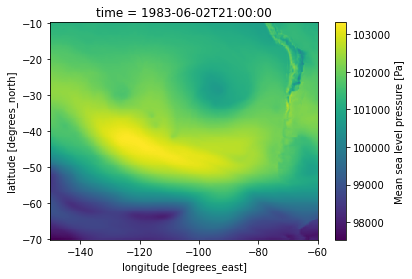

In [2]:
Desde = '1979-12-30 21:00:00'
Hasta = '2009-12-30 21:00:00'  

names = ['download(1979-1988).nc',
         'download(1989-1999).nc',
         'download(2000-2009).nc',
         ]

files = [Data + name for name in names]
dswind= xr.open_mfdataset(files)

"""Datos del viento """

longitude=slice(-150,-60)
latitude=slice(-10,-80)

msl = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=longitude,latitude=latitude)



msl.isel(time =10000).plot()

### Oleaje:

Se cuenta con parámetros resumen de oleaje cada tres horas, entre el año 1979 y el 2010 en Valparaíso aguas profundas (N:-33, E:-72), distribuidos por la NCEP. 
- `df0` es un dataframe que contiene los parámetros resumen `Hm0, Tp, Dm y Dsd` en forma de csv. 
- `df02` es un dataframe que contiene el parámetro resumen `Tm` en forma de csv. 

(originalmente estos dataframe corresponden a un archivo _.dfs0_ de Mikeio, pero fueron transformados a _.csv_ debido a que la librería Mikeio de python no está disponible para Macos)

In [3]:
df0 = pd.read_csv(Data + 'NCEP_Spectra2.csv',index_col='Unnamed: 0')  #Sólo los parámetros de oleaje, no es el espectro completo.
df02 = pd.read_csv(Data + 'NCEP_Spectra_from_Partitions_33.0S_72W_197901to200912_paramsMIKE.csv',index_col='Unnamed: 0')  #parámetros de periodo medio
Fechas = df0[Desde: Hasta].index

## Funciones creadas a utilizar

Se compilan todas las funciones con una breve descripción. Se irán usando a medida que se avance en el código.

In [5]:


def resize(Wind,i,j=1,padding='valid'):
    
    '''Wind: array de dimensión (m, latitud, longitud) o  (m, latitud, longitud, canales)
    i: int, indica tamaño del pool size
    j: int, indica tamaño del strides
    
    return: array de entrada con menor resolución. Dimensión (m, latitud/j, longitud/j, canales) '''
    
    if len(Wind.shape) ==3:
    
        Wind = Wind.reshape(Wind.shape[0], Wind.shape[1], Wind.shape[2],1)

    Average_pool = AveragePooling2D(pool_size = i,strides = j ,padding=padding)#, strides= int(10*i)) #el poolsize y stride, están pensados para las futuras iteraciones
    model = Sequential([Average_pool]) 
    output = model.predict(Wind)    
    Wind = np.squeeze(output) 
    
    return Wind


def gradiente(X):
    
    '''Obtener el gradiente de presión'''
    
    grad = np.zeros(X.shape)
    for i in range(1,grad.shape[1]-1):       
        for j in range(1,grad.shape[2]-1):           
            grad[:,i,j] = np.sqrt((X[:,i-1,j]-X[:,i+1,j])**2 + (X[:,i,j-1]-X[:,i,j+1])**2) #magnitud de gradiente aunque le falta ser dividida por el diferencial de distancia entre puntos, pero al ser constante para todos los valores no debería afectar.
    
    return grad


def flatten(Var):   
    '''Funcion que realiza una transformación lineal de dimensión 3 a dimensión 2 '''
    
    return Var.reshape(Var.shape[0], Var.shape[1]*Var.shape[2])


def preparar_x(dswind, lotes = 20000, pooling = 1, flat = False):

    '''
    Función para poder crear un arreglo de datos que contenga todos los dato del dataserie,
    
    Es relevante, ya que se debe hacer por lotes para no exceder la capacidad de la RAM.
    
    lotes: int, corresponde al tamaño de cada lote a procesar mediante un avarage pooling
    
    pooling: int, densidad del avarage pooling.
    
    return, arreglo X correspondiente a la base de datos dswind completa con dimensión reducida

    '''

    Largototal = dswind.data.shape[0]
    j = lotes
    X = resize(np.array(dswind.isel(time = slice(0,j)).data), pooling, pooling)

    
    for i in range(lotes*2,Largototal,lotes):      
        windpart = resize(np.array(dswind.isel(time = slice(j,i)).data), pooling, pooling)      
        X = np.append(X,windpart, axis = 0)       
        j = i      
        
        print('Datos: ',i,'/',Largototal)
        
    windpart = resize(np.array(dswind.isel(time = slice(j,Largototal)).data), pooling, pooling)
    X = np.append(X,windpart, axis = 0)
    
    if flat:       
        X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
    
    return X

def RMSE(real, estimado):    
    '''
    Raíz del error cuadrático medio'''
    
    return np.sqrt((np.square(real - estimado)).mean())

def MSE(real, estimado):
    '''
    error cuadrático medio'''
    
    return ((np.square(real - estimado)).mean())

def normalize(X):
    '''Normaliza los datos entre 1 y 0
    Es usada para el X de entrenamiento'''
    
    return (X-X.min())/(X.max()-X.min())

def get_set(X, Y, traslape, timestep = 1):    
    '''
    X: array de numpy de dimensión (m, features_input)
    Y: array de numpy de dimensión (m, features_output)
    timestep: int, tamaño de cada espacio de tiempo a pronosticar
    traslape: int, entrenamiento previo al pronóstico para cada sub serie de tiempo
    
    return x e y de entrenamiento y validación para usar el modelo NN
    '''
    
    scx = MinMaxScaler([0,1]) 
    
    #Se normaliza X entre 0,1, y se normaliza Y entre 0,1 guardando su factor scx para invertir el mismo set luego del pronóstico.
    
    X_div, Y_div =  dividir(normalize(X),scx.fit_transform(Y),  traslape,timestep) 

    
    m = X_div.shape[0]

    x_train, x_test = X_div[:int(m*0.8)], X_div[int(m*0.8):]

    y_train, y_test = Y_div[:int(m*0.8)], Y_div[int(m*0.8):]

    print('X_train shape: ', x_train.shape)
    print('Y_train shape: ', y_train.shape)

    return x_train, x_test, y_train, y_test, scx


def juntar(Var):
    
    '''Luego de pronosticar con la red neuronl, se juntan las subseries, en una serie continua'''
    
    return Var.reshape(Var.shape[0]*Var.shape[1],Var.shape[2])


def dividir(Var1, Var2,  desfase, timestep=1):
    
    '''Se puede pronosticar Many-to-one (regresor común) o Many-to-many (red recurrente)'''
    
    '''Divide las series Var1 y Var2 en sub series de tamaño timestep más el tamaño de la memoria, de desfases a incluir.
    esta funcion se usa dentro de get_set'''
    
    Var1_d = []
    for t in range(timestep+desfase, Var1.shape[0],timestep):  
        Var1_d.append(Var1[t - timestep -desfase:t])
    Var1_d = np.array(Var1_d)
    
    Var2_d = []
    for t in range(timestep+desfase, Var2.shape[0],timestep):         
        Var2_d.append(Var2[t - timestep:t])
    Var2_d = np.array(Var2_d)    
     
    return Var1_d, Var2_d

## Correlación de las área de generación

Para estudiar la influencia sobre el oleaje en Valparaiso producto del viento en cada sector del pacífico, se recurre a promediar áreas de viento usando un `pooling`. De esta forma se obtienen valores promedio de la presión superficial dentro de cada sub-area. Luego se calcula la **correlación** entre el registro histórico de cada área contra cada variable de oleaje.

Se usará una muestra de datos de 5 años para abarcar un area más extensa.

In [6]:
Desde = '2004-12-30 21:00:00'
Hasta = '2009-12-30 21:00:00'  

longitude=slice(-150,-60)
latitude=slice(-10,-80)

msl = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=longitude,latitude=latitude)



In [7]:
Wind = np.array(msl)

In [262]:
Wind=resize(Wind,20,20)

<ipython-input-272-d62cc60a2de8>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X,Y,Wind[1000,:,:])


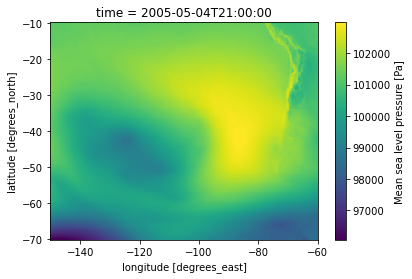

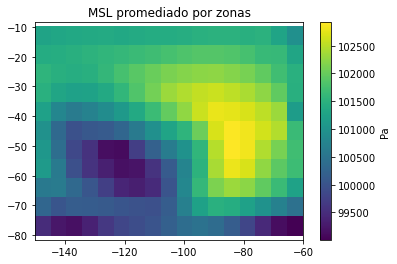

In [272]:
x = np.linspace(-150,-60,num=18)
y = np.linspace(-10,-80,num=12)
X, Y = np.meshgrid(x,y)

msl.isel(time=1000).plot()

fig=plt.figure()
plt.axis('equal')
plt.title("MSL promediado por zonas")
plt.xlabel ='Longitud'
plt.ylabel= 'Latitud'
plt.pcolor(X,Y,Wind[1000,:,:])
plt.colorbar(label='Pa')


In [8]:
Hm0 = np.array(df0[Desde: Hasta]['Hm0'])
Tp = np.array(df0[Desde: Hasta]['Tp'])
Dm = np.array(df0[Desde: Hasta]['Mean Dir'])
DSD =  np.array(df0[Desde: Hasta]['DSD'])
Tm = np.array(df02[Desde: Hasta]['P1: Wave Period, T01'])

oleaje = [Hm0, Tp, Dm, DSD, Tm]

In [9]:
for ola in oleaje:
    np.corrcoef(ola[10:],Wind[:-10,0,0])

### Se calculan las correlaciones para cada variable de oleaje versus la zona de generación.

El cálculo de la correlación entre cada area de generación y variable de oleaje se realiza para distintos desfases entre las variables. De esta forma se puede ver la correlación que hay entre un dos registros con una diferencia hasta de 7 días. (correspondiente a 56 desfases, 7 días x 8 registros diarios)

In [324]:
memoria = 56

R = np.zeros([memoria, Wind.shape[1],Wind.shape[2],len(oleaje)])

for desfase in range(1,memoria):   
    j = 0
    for parametro in oleaje:
        for row in range(Wind.shape[1]):
            for col in range(Wind.shape[2]):
                R[desfase,row,col,j]= np.corrcoef(parametro[desfase:],Wind[:-desfase,row,col])[0,1] 
        j+=1

<ipython-input-388-dd07e48cf063>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[j].pcolor(X,Y,R[t,:,:,j],cmap='RdBu',vmin=-0.4,vmax=0.4)
<ipython-input-388-dd07e48cf063>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  fig.colorbar(axs[ 0].pcolor(X,Y,R[t,:,:,j],cmap='RdBu',vmin=-0.4,vmax=0.4), ax=axs[ :], location='right', shrink=0.6)


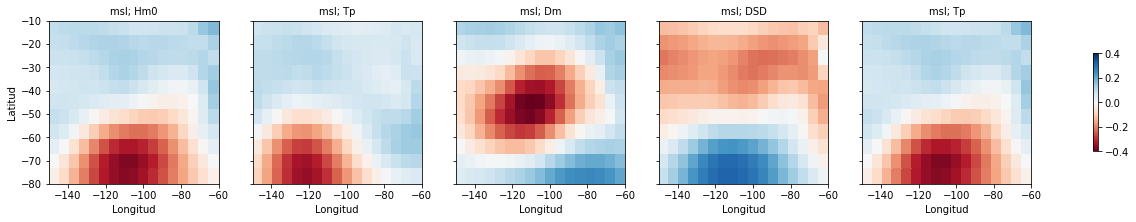

In [388]:
wind = ['msl']
wave = ['Hm0','Tp','Dm','DSD','Tp']

fig, axs = plt.subplots(1, len(oleaje),figsize=(22,3))
t=40

for j in range(len(oleaje)):
    axs[j].pcolor(X,Y,R[t,:,:,j],cmap='RdBu',vmin=-0.4,vmax=0.4)
    axs[j].set_title(wind[0]+'; '+wave[j],fontsize=10)

for ax in axs.flat:
    ax.set(xlabel='Longitud', ylabel='Latitud')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.colorbar(axs[ 0].pcolor(X,Y,R[t,:,:,j],cmap='RdBu',vmin=-0.4,vmax=0.4), ax=axs[ :], location='right', shrink=0.6)
fig.set_facecolor('w')
plt.savefig("correlaciones3.5.png")



## Gráficos de correlación para distintos tiempos de desfase según zona de generación

A continuación se grafica la evolución de la correlación para destintos desfases de datos.

Estos graficos nos ayudan a comprender los desfases y correlaciones que tiene cada zona de generación

In [334]:
Wind=resize(Wind,4,4)

In [336]:
memoria = 80

R2 = np.zeros([memoria, Wind.shape[1],Wind.shape[2],len(oleaje)])

for desfase in range(1,memoria):   
    j = 0
    for parametro in oleaje:
        for row in range(Wind.shape[1]):
            for col in range(Wind.shape[2]):
                R2[desfase,row,col,j]= np.corrcoef(parametro[desfase:],Wind[:-desfase,row,col])[0,1]**2
        j+=1

- El mapa de presiones que se muestra en la figura anterior se divide en 12 zonas distribuidas de la siguiente forma:

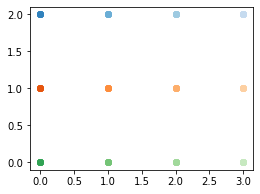

In [384]:
palette = plt.get_cmap('tab20c')
fig, axs = plt.subplots(1, 1,figsize=(4,3))
tiempo = np.arange(0,80)
for var in range(5):
    col=-1
    for i in range(3):
        for j in range(4):
            col+=1
            axs.plot(j,2-i,'o',c=palette(col))

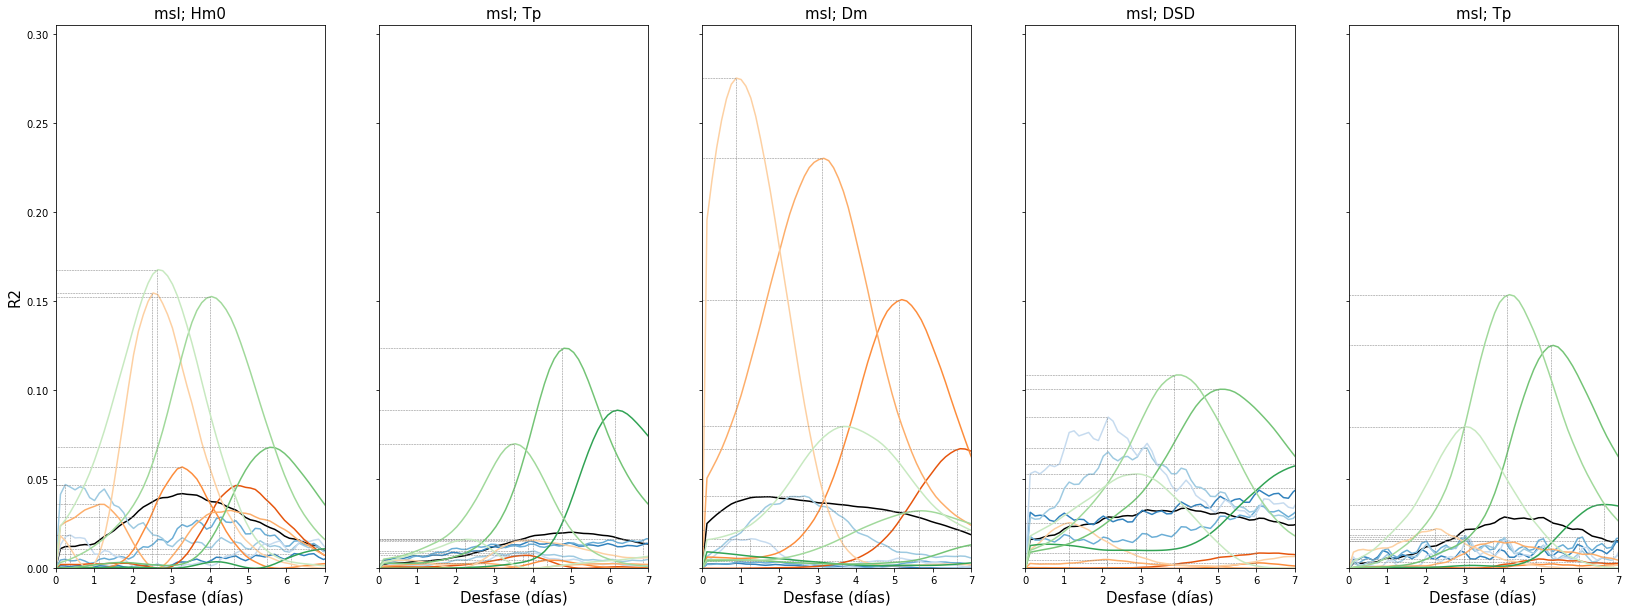

In [385]:


fig, axs = plt.subplots(1, 5,figsize=(28,10))
tiempo = np.linspace(0,10,80)
for var in range(5):
    col=-1
    axs[var].plot(tiempo,np.mean(np.mean(R2[:,:,:,var],axis=1),axis=1),c='black')
    for i in range(3):
        for j in range(4):
            col+=1
            
            axs[var].plot(tiempo,R2[:,i,j,var], c=palette(col))
            
            y=np.max(R2[:,i,j,var])
            x=int(np.where(R2[:,i,j,var]==y)[0])*3/24

            axs[ var].plot([x,x,0],[0,y,y],'grey',linewidth=0.5,linestyle='dashed')
            #axs[ var].legend(['('+str(i+1)+', '+str(j+1)+')'])
            #axs[ var].text(x-0.6,y+0.02,'('+str(round(x,1))+', '+str(round(y,2))+')')
            axs[ var].set_title(wind[0]+'; '+wave[var],fontsize=15)
            axs[ var].set_ylim(np.min(R2[:,:,:,:]),np.max(R2[:,:,:,:])+0.03)
            axs[ var].set_xlim(0,7)
            axs[ var].xaxis.label.set_size(15)
            axs[ var].yaxis.label.set_size(15)
        

for ax in axs.flat:
    ax.set(xlabel='Desfase (días)',ylabel='R2')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

- Los gráficos muestran que los parámetros resumen `Hm0, Tp, Tm y DSD` tienen mejor correlación con la zona de generación verde correspondiente a la latitud N-55, N-80.
- Por otro lado, el parámetro `Dm` tiene mejor correlación con las latitudes cercanas al rango N-35, N-55



## Obtención del vector de características (features)


Luego de definido el area de influencia se realiza una iteración con distintos modelos pre-entrenados obtenidos de la librería `Keras`. https://keras.io/api/applications/

Esta sección define dos inputs que serán usado para entrenar los modelos de ML y DL:
- X_1: Input de valores de presión
- X_2: Input de características de mapa de presión


In [74]:
Desde = '2000-12-30 21:00:00'
Hasta = '2009-12-30 21:00:00'  

longitude=slice(-130,-70)
latitude=slice(-20,-80)

msl = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=longitude,latitude=latitude)


Hm0 = np.array(df0[Desde: Hasta]['Hm0']).reshape(-1,1)
Tp = np.array(df0[Desde: Hasta]['Tp']).reshape(-1,1)
Dm = np.array(df0[Desde: Hasta]['Mean Dir']).reshape(-1,1)
DSD =  np.array(df0[Desde: Hasta]['DSD']).reshape(-1,1)
Tm = np.array(df02[Desde: Hasta]['P1: Wave Period, T01']).reshape(-1,1)

oleaje = [Hm0, Tp, Dm, DSD, Tm]

time = np.array(df0[Desde: Hasta].index, dtype='datetime64[ns]')

msl.shape

(26297, 201, 241)

Es necesario usar la función `preparar_x` para que bajar la resolución a los datos cuando el arreglo `xarray` tiene dimensiones superiores a la capacidad de la memoria RAM
Esta función transforma el arreglo en vectores de tamaño accesible para el computador, para poder bajar la resolución de los datos.

In [11]:
X_1 = preparar_x(msl,5000,2)


Datos:  10000 / 26297
Datos:  15000 / 26297
Datos:  20000 / 26297
Datos:  25000 / 26297


In [12]:
X_1.shape

(26297, 100, 120)

In [13]:
X_1 = normalize(X_1)   #Se normaliza.

np.save(Cache + 'msl(2000-2010).npy', X_1)

#X_1 = np.load(Cache + 'msl(2000-2010).npy')

In [11]:
X_1_3 = (np.repeat(X_1[..., np.newaxis], 3, -1)) #Se repite en 3 para poder ingresar al modelo pre-entrenado. 

In [472]:
x = tf.keras.applications.vgg16.preprocess_input(
    X_1_3, data_format=None)

In [12]:
from tensorflow.keras.applications import InceptionV3, ResNet50, Xception,InceptionResNetV2, ResNet152V2, VGG16

input_tensor = Input(shape=(X_1_3.shape[1], X_1_3.shape[2], 3))

model =  VGG16(input_tensor=input_tensor , weights = 'imagenet', include_top =False)

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 30, 128)       0     

In [13]:
X_2 = model.predict(X_1_3)   #Tarda 28 minutos en calcular 10 años.

#Bajamos la dimensión y transformamos a vector.

X_2 = resize(X_2,3,True)

np.save(Cache + 'x_features_VGG(2000-2010).npy', X_2)

print('Se guardó, ya tenemos el X de características')

Se guardó, ya tenemos el X de características


In [14]:
'''Aquí se carga como X input las características obtenidas de la red VGG16 anteriormente"'''

X_2 = np.load(Cache + 'x_features_VGG(2000-2010).npy')

X_2.shape

(26297, 512)

In [15]:
"'Se carga X como los valores de presión, omitir si se quiere usar el X features del modelo pre-entrenado'"

X_1 = np.load(Cache + 'msl(2000-2010).npy')

X_1 = flatten(resize(X_1 ,5,5,padding="same"))

X_1.shape

(26297, 480)

# Evaluación de los modelos ML y DL

Para pronosticar un parámetro del espectro de oleaje se usará primero el regresor Ridge de la librería `sckit-learn`.

## Regresor Ridge

### 1.1 Regresor Ridge  sin red VGG16

Tiempo de entrenamiento 10 años, 3 minutos por parámetro

In [16]:
def regresor_ridge(X,Y):

    X2, Y = dividir(X, Y, desfase=60) #Desfases que incluirá la memoria del regresor.
    X2 = flatten(X2)
    Y= flatten(Y)

    #Separamos en sets de entrenamiento y de validación

    m = X2.shape[0]  

    x_train_feat = X2[int(m*0.0):int(m*0.8)]
    x_test_feat = X2[int(m*0.8):int(m*1)]
    y_train_f = Y[int(m*0.0):int(m*0.8)]
    y_test_f = Y[int(m*0.8):int(m*1)]

    #Creamos el regresor

    regresor = linear_model.Ridge(alpha=.5,normalize=True)

    #Entrenamos el regresor

    regresor = regresor.fit(x_train_feat,y_train_f)
    y_pred_t = regresor.predict(x_test_feat)
    
    return y_test_f, y_pred_t

nombres = ['Hm0', 'Tp', 'Dm', 'DSD', 'Tm']

In [17]:
pronosticos = []
for i in range(len(oleaje)):
    y_test_f, y_pred_t = regresor_ridge(X_1,oleaje[i])
    pronosticos.append([y_test_f, y_pred_t])
    print('Resultados ',nombres[i],' - con input presión msl:')
    print('r: ', np.round(np.corrcoef(y_test_f.T,y_pred_t.T)[0,1],3), '  RMSE: ',RMSE(y_test_f.T,y_pred_t.T))

Resultados  Hm0  - con input presión msl:
r:  0.728   RMSE:  0.4351570648680055
Resultados  Tp  - con input presión msl:
r:  0.395   RMSE:  1.9115350114811986
Resultados  Dm  - con input presión msl:
r:  0.846   RMSE:  6.902263560686964
Resultados  DSD  - con input presión msl:
r:  0.59   RMSE:  5.076622312711576
Resultados  Tm  - con input presión msl:
r:  0.587   RMSE:  1.5028904874752664


### 1.2 Regresor Ridge  con red VGG16

Tiempo de entrenamiento 10 años, 4 minutos por cada parámetro resumen.

In [18]:
pronosticos_VGG = []
for i in range(len(oleaje)):
    y_test_f, y_pred_t = regresor_ridge(X_2,oleaje[i])
    pronosticos_VGG.append([y_test_f, y_pred_t])
    print('Resultados ',nombres[i],' - con input presión msl:')
    print('r: ', np.round(np.corrcoef(y_test_f.T,y_pred_t.T)[0,1],3), '  RMSE: ',RMSE(y_test_f.T,y_pred_t.T))

Resultados  Hm0  - con input presión msl:
r:  0.763   RMSE:  0.41023957548169004
Resultados  Tp  - con input presión msl:
r:  0.419   RMSE:  1.984147865185603
Resultados  Dm  - con input presión msl:
r:  0.744   RMSE:  9.192405590837467
Resultados  DSD  - con input presión msl:
r:  0.481   RMSE:  5.854321721432446
Resultados  Tm  - con input presión msl:
r:  0.515   RMSE:  1.6743405352762069


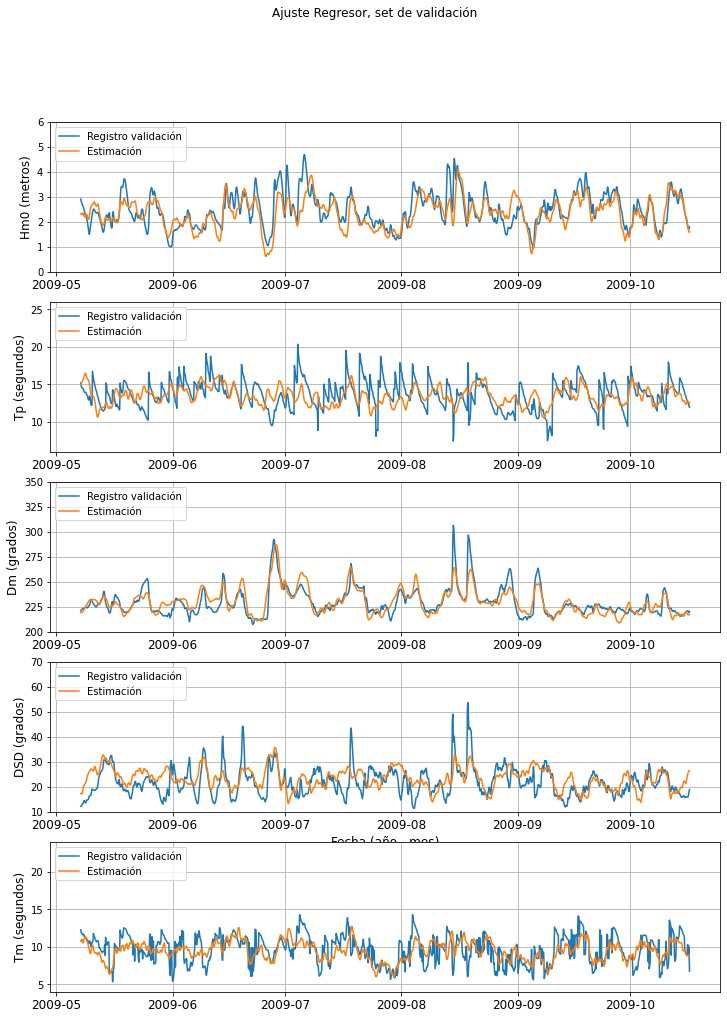

In [76]:
pronostico = np.array(pronosticos)
#pronostico = pronosticos_VGG

fig, axs = plt.subplots(5, 1, figsize=(12,16))

fig.suptitle('Ajuste Regresor, set de validación',fontsize=12)




axs[0].plot(time[-1900:-600],pronostico[0,0][-1900:-600],label='Registro validación')
axs[0].plot(time[-1900:-600],pronostico[0,1][-1900:-600],label="Estimación ")
axs[0].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[0].set_ylabel('Hm0 (metros)',size=12)
axs[0].set_ylim(0,6)
axs[0].legend(loc=2)
axs[0].grid()

axs[1].plot(time[-1900:-600],pronostico[1,0][-1900:-600],label='Registro validación')
axs[1].plot(time[-1900:-600],pronostico[1,1][-1900:-600],label="Estimación ")
axs[1].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[1].set_ylabel('Tp (segundos)',size=12)
axs[1].set_ylim(6, 26)
axs[1].legend(loc=2)
axs[1].grid()

axs[2].plot(time[-1900:-600],pronostico[2,0][-1900:-600],label='Registro validación')
axs[2].plot(time[-1900:-600],pronostico[2,1][-1900:-600],label="Estimación ")
axs[2].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[2].set_ylabel('Dm (grados)',size=12)
axs[2].set_ylim(200,350)
axs[2].legend(loc=2)
axs[2].grid()

axs[3].plot(time[-1900:-600],pronostico[3,0][-1900:-600],label='Registro validación')
axs[3].plot(time[-1900:-600],pronostico[3,1][-1900:-600],label="Estimación ")
axs[3].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[3].set_ylabel('DSD (grados)',size=12)
axs[3].set_ylim(10,70)
axs[3].set_xlabel("Fecha (año - mes)",size=12)
axs[3].legend(loc=2)
axs[3].grid()

axs[4].plot(time[-1900:-600],pronostico[4,0][-1900:-600],label='Registro validación')
axs[4].plot(time[-1900:-600],pronostico[4,1][-1900:-600],label="Estimación ")
axs[4].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[4].set_ylabel('Tm (segundos)',size=12)
axs[4].set_ylim(4,24)
axs[4].legend(loc=2)
axs[4].grid()

Se itera en cada parámetro de oleaje para obtener las correlaciones y los RMSE de cada uno.

## LSTM - FCL

### 2.1 LSTM - FCL sin red VGG16

Primero se crea la arquitectura

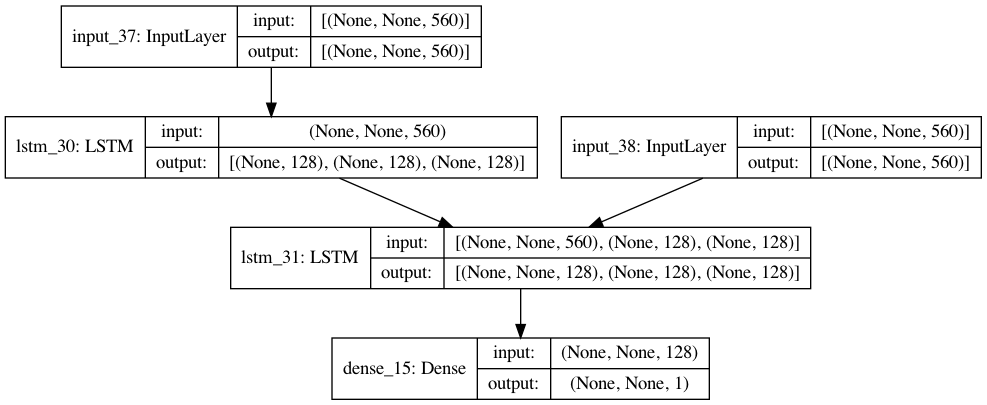

In [464]:

num_decoder_tokens = 1

hidden_units = 128

# Define an input sequence and process it.

encoder_inputs = Input(shape=(None, X_1.shape[1]))

encoder = LSTM(hidden_units, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None, X_1.shape[1]))#,x_train.shape[3],x_train.shape[4]))


decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

#decoder_outputs = Dropout(0.5)(decoder_outputs)

decoder_outputs = Dense(num_decoder_tokens)(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

plot_model(model, to_file=Imagenes + 'model_parámetros.png', show_shapes=True)

- Se corre un modelo para cada parámetro de oleaje y se guardan los ajustes del set de validación

In [467]:
#Se crea los set de entrenamiento y validación para el parámetro Hm0
traslape = 60

x_train, x_test, y_train, y_test, scy = get_set(X_2, Hm0, traslape=traslape )

#se compila un modelo nuevo con la estructura anterior
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')

#Se entrena el modelo
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 20,batch_size=64 ,validation_split=0.1, shuffle = True)

#Se hace la predicción con el set de validación
y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))
y_test = scy.inverse_transform(juntar(y_test))
y_train = scy.inverse_transform(juntar(y_train[:1000]))
y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:1000,:traslape,:],x_train[:1000,traslape:,:]])))

np.save(Cache + 'Hm0_test_3.npy', y_test)
np.save(Cache + 'Hm0_pred_3.npy', y_pred_test)

X_train shape:  (20988, 61, 560)
Y_train shape:  (20988, 1, 1)
Epoch 1/20
296/296 [==============================] - 35s 96ms/step - loss: 0.4442 - val_loss: 0.0212
Epoch 2/20
296/296 [==============================] - 27s 92ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 3/20
296/296 [==============================] - 27s 90ms/step - loss: 0.0199 - val_loss: 0.0207
Epoch 4/20
296/296 [==============================] - 27s 91ms/step - loss: 0.0199 - val_loss: 0.0215
Epoch 5/20
296/296 [==============================] - 26s 89ms/step - loss: 0.0199 - val_loss: 0.0205
Epoch 6/20
296/296 [==============================] - 26s 88ms/step - loss: 0.0200 - val_loss: 0.0216
Epoch 7/20
296/296 [==============================] - 26s 87ms/step - loss: 0.0201 - val_loss: 0.0215
Epoch 8/20
296/296 [==============================] - 26s 88ms/step - loss: 0.0195 - val_loss: 0.0213
Epoch 9/20
296/296 [==============================] - 26s 89ms/step - loss: 0.0203 - val_loss: 0.0202
Epoch 10/20
296/296

In [221]:
x_train, x_test, y_train, y_test, scy = get_set(X_2, Tp, timestep= 1, traslape = traslape)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')
    
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 60,batch_size=32 ,validation_split=0.1, shuffle = True)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

y_train = scy.inverse_transform(juntar(y_train[:1000]))

y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:1000,:traslape,:],x_train[:1000,traslape:,:]])))

np.save(Cache + 'Tp_test_3.npy', y_test)
np.save(Cache + 'Tp_pred_3.npy', y_pred_test)

X_train shape:  (28011, 51, 460)
Y_train shape:  (28011, 1, 1)
Epoch 1/60
788/788 [==============================] - 40s 48ms/step - loss: 0.0188 - val_loss: 0.0153
Epoch 2/60
788/788 [==============================] - 37s 47ms/step - loss: 0.0181 - val_loss: 0.0128
Epoch 3/60
788/788 [==============================] - 37s 47ms/step - loss: 0.0180 - val_loss: 0.0131
Epoch 4/60
788/788 [==============================] - 36s 46ms/step - loss: 0.0174 - val_loss: 0.0124
Epoch 5/60
788/788 [==============================] - 36s 46ms/step - loss: 0.0175 - val_loss: 0.0126
Epoch 6/60
788/788 [==============================] - 37s 46ms/step - loss: 0.0174 - val_loss: 0.0146
Epoch 7/60
244/788 [========>.....................] - ETA: 25s - loss: 0.0184

KeyboardInterrupt: 

In [9]:
x_train, x_test, y_train, y_test, scy = get_set(X_3, Dp, timestep= 1, traslape = 60)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')
    
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)


y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))


np.save(Cache + 'MD_test_3.npy', y_test)

np.save(Cache + 'MD_pred_3.npy', y_pred_test)



x_train, x_test, y_train, y_test, scy = get_set(X_3, DSD, timestep= 1, traslape = 60)

traslape =60

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.save(Cache + 'DSD_test_3.npy', y_test)
np.save(Cache + 'DSD_pred_3.npy', y_pred_test)

DSD_test = y_test
DSD_pred = y_pred_test


x_train, x_test, y_train, y_test, scy = get_set(X_3, Tm, timestep= 1, traslape = 60)

traslape =60

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 30,batch_size=64 ,validation_split=0.1, shuffle = True)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.save(Cache + 'WP_test_3.npy', y_test)
np.save(Cache + 'WP_pred_3.npy', y_pred_test)

X_train shape:  (72411, 61, 560)
Y_train shape:  (72411, 1, 1)
Epoch 1/30
1019/1019 [==============================] - 133s 122ms/step - loss: 0.0113 - val_loss: 0.0071
Epoch 2/30
1019/1019 [==============================] - 99s 97ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 3/30
1019/1019 [==============================] - 95s 93ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 4/30
1019/1019 [==============================] - 104s 102ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 5/30
1019/1019 [==============================] - 94s 92ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 6/30
1019/1019 [==============================] - 98s 97ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 7/30
1019/1019 [==============================] - 96s 94ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/30
1019/1019 [==============================] - 105s 103ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 9/30
1019/1019 [==============================] - 94s 92ms/step - loss: 0.0042 - val_loss: 0.

Epoch 17/30
1019/1019 [==============================] - 87s 86ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 18/30
1019/1019 [==============================] - 87s 86ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 19/30
1019/1019 [==============================] - 86s 85ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 20/30
1019/1019 [==============================] - 86s 84ms/step - loss: 0.0157 - val_loss: 0.0151
Epoch 21/30
1019/1019 [==============================] - 87s 85ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 22/30
1019/1019 [==============================] - 87s 85ms/step - loss: 0.0158 - val_loss: 0.0149
Epoch 23/30
1019/1019 [==============================] - 86s 85ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 24/30
1019/1019 [==============================] - 88s 86ms/step - loss: 0.0155 - val_loss: 0.0148
Epoch 25/30
1019/1019 [==============================] - 87s 86ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 26/30
1019/1019 [==============================] 

In [77]:
#Los parámetros entrenados anteriormente se pueden cargar acá


Hm0_test = np.load(Cache + 'Hm0_test.npy')
Hm0_pred = np.load(Cache + 'Hm0_pred.npy')

Tp_test = np.load(Cache + 'Tp_test.npy')
Tp_pred = np.load(Cache + 'Tp_pred.npy') 

WP_test = np.load(Cache + 'WP_test.npy')
WP_pred = np.load(Cache + 'WP_pred.npy') 

MD_test = np.load(Cache + 'MD_test.npy')
MD_pred = np.load(Cache + 'MD_pred.npy')

DSD_test = np.load(Cache + 'DSD_test.npy')
DSD_pred = np.load(Cache + 'DSD_pred.npy')

In [78]:
print('Raíz del error cuatrático medio')
print('Hm0: ', RMSE(Hm0_test,Hm0_pred))
print('Tm: ', RMSE(WP_test,WP_pred))
print('Tp: ', RMSE(Tp_test,Tp_pred))
print('Mean Dir: ', RMSE(MD_test,MD_pred))
print('DSD: ',RMSE(DSD_test,DSD_pred))

Raíz del error cuatrático medio
Hm0:  0.41386147876600776
Tm:  1.481854913675738
Tp:  1.8822223658937378
Mean Dir:  8.326998510070771
DSD:  5.1786004863529085


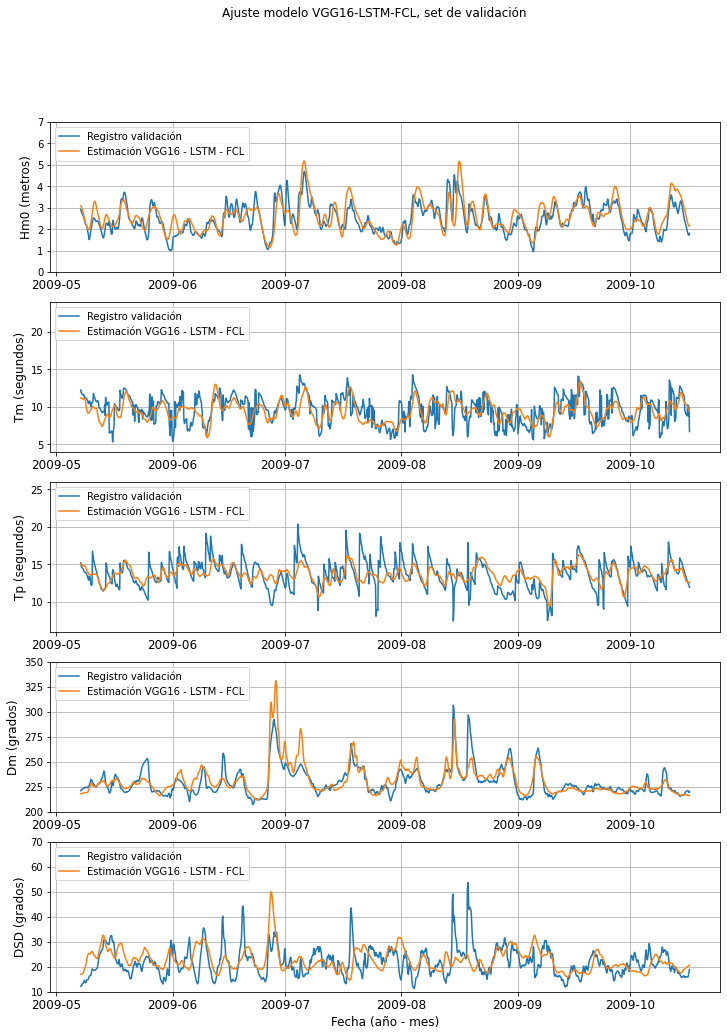

In [79]:
fig, axs = plt.subplots(5, 1, figsize=(12,16))

fig.suptitle('Ajuste modelo VGG16-LSTM-FCL, set de validación',fontsize=12)

axs[0].plot(time[-1900:-600],Hm0_test[-1900:-600],label='Registro validación')
axs[0].plot(time[-1900:-600],Hm0_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[0].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[0].set_ylabel('Hm0 (metros)',size=12)
axs[0].set_ylim(0,7)
axs[0].legend(loc=2)
axs[0].grid()

axs[1].plot(time[-1900:-600],WP_test[-1900:-600],label='Registro validación')
axs[1].plot(time[-1900:-600],WP_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[1].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[1].set_ylabel('Tm (segundos)',size=12)
axs[1].set_ylim(4,24)
axs[1].legend(loc=2)
axs[1].grid()


axs[2].plot(time[-1900:-600],Tp_test[-1900:-600],label='Registro validación')
axs[2].plot(time[-1900:-600],Tp_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[2].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[2].set_ylabel('Tp (segundos)',size=12)
axs[2].set_ylim(6, 26)
axs[2].legend(loc=2)
axs[2].grid()

axs[3].plot(time[-1900:-600],MD_test[-1900:-600],label='Registro validación')
axs[3].plot(time[-1900:-600],MD_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[3].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[3].set_ylabel('Dm (grados)',size=12)
axs[3].set_ylim(200,350)
axs[3].legend(loc=2)
axs[3].grid()

axs[4].plot(time[-1900:-600],DSD_test[-1900:-600],label='Registro validación')
axs[4].plot(time[-1900:-600],DSD_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[4].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[4].set_ylabel('DSD (grados)',size=12)
axs[4].set_ylim(10,70)
axs[4].set_xlabel("Fecha (año - mes)",size=12)
axs[4].legend(loc=2)
axs[4].grid()



fig.set_facecolor('w')
fig.savefig(Imagenes + 'Serie de tiempo', dpi=300)



In [28]:
def QQ(test, pred, ax):
    percs = np.linspace(0,100,31)
    qn_a = np.percentile(test, percs)
    qn_b = np.percentile(pred, percs)
    return axs[ax].plot(qn_a,qn_b, ls="", marker="o", color='red')

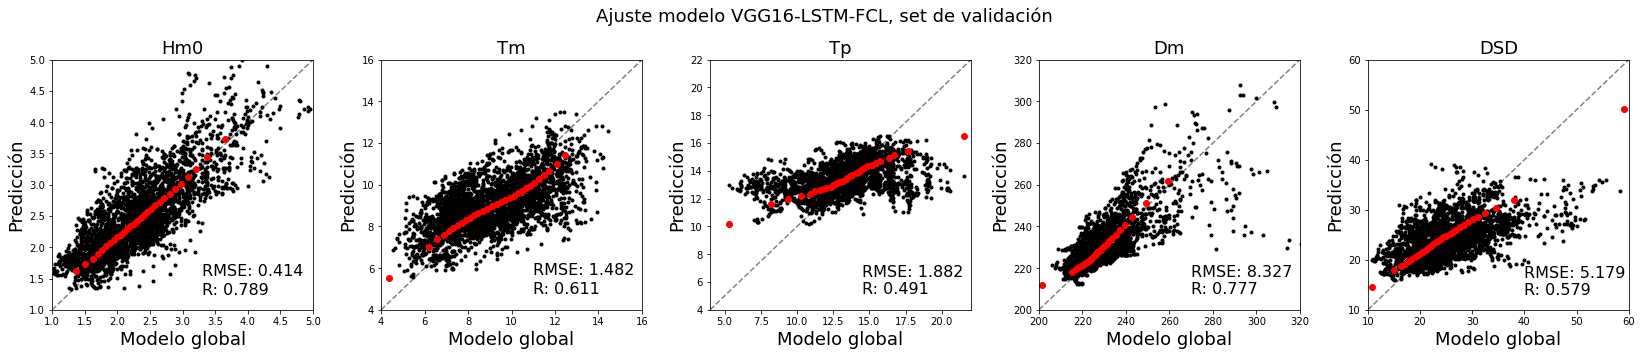

In [102]:
#Gráfico de los ajustes de los parámetros

fig, axs = plt.subplots(1, 5, figsize=(23,5))

fig.suptitle('Ajuste modelo VGG16-LSTM-FCL, set de validación',fontsize=18)



axs[0].set_title('Hm0',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(Hm0_test[:3000,0],Hm0_pred[:3000,0],'.',color='Black')
axs[0].set_xlabel('Modelo global',size=18)
axs[0].set_ylabel('Predicción',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.3,1.25,'R: '+str(np.round(np.corrcoef(Hm0_test.T,(Hm0_pred).T)[0,1],3)),size=16)
axs[0].text(3.3,1.55,'RMSE: '+str(np.round(RMSE(Hm0_test.T,(Hm0_pred).T),3)),size=16)
QQ(Hm0_test, Hm0_pred, 0)


axs[1].set_title('Tm',fontsize=18)
axs[1].plot([4,16],[4,16],'--',0.5,color='grey')
axs[1].plot(WP_test[:3000],WP_pred[:3000],'.',color='Black')
axs[1].set_xlabel('Modelo global',size=18)
axs[1].set_ylabel('Predicción',size=18)
axs[1].set_ylim(4,16)
axs[1].set_xlim(4,16)
axs[1].text(11,4.8,'R: '+str(np.round(np.corrcoef(WP_test.T,(WP_pred).T)[0,1],3)),size=16)
axs[1].text(11,5.7,'RMSE: '+str(np.round(RMSE(WP_test.T,(WP_pred).T),3)),size=16)
QQ(WP_test, WP_pred, 1)

axs[2].set_title('Tp',fontsize=18)
axs[2].plot([4,22],[4,22],'--',0.5,color='grey')
axs[2].plot(Tp_test[:3000],Tp_pred[:3000],'.',color='Black')
axs[2].set_xlabel('Modelo global',size=18)
axs[2].set_ylabel('Predicción',size=18)
axs[2].set_ylim(4,22)
axs[2].set_xlim(4,22)
axs[2].text(14.5,5.2,'R: '+str(np.round(np.corrcoef(Tp_test.T,(Tp_pred).T)[0,1],3)),size=16)
axs[2].text(14.5,6.4,'RMSE: '+str(np.round(RMSE(Tp_test.T,(Tp_pred).T),3)),size=16)
QQ(Tp_test[:3000],Tp_pred[:3000], 2)

axs[3].set_title('Dm',fontsize=18)
axs[3].plot([200,320],[200,320],'--',0.5,color='grey')
axs[3].plot(MD_test[:3000],MD_pred[:3000],'.',color='Black')
axs[3].set_xlabel('Modelo global',size=18)
axs[3].set_ylabel('Predicción',size=18)
axs[3].set_ylim(200,320)
axs[3].set_xlim(200,320)
axs[3].text(270,208,'R: '+str(np.round(np.corrcoef(MD_test.T,(MD_pred).T)[0,1],3)),size=16)
axs[3].text(270,216,'RMSE: '+str(np.round(RMSE(MD_test.T,(MD_pred).T),3)),size=16)
QQ(MD_test, MD_pred, 3)


axs[4].set_title('DSD',fontsize=18)
axs[4].plot([10,60],[10,60],'--',0.5,color='grey')
axs[4].plot(DSD_test[:3000],DSD_pred[:3000],'.',color='Black')
axs[4].set_xlabel('Modelo global',size=18)
axs[4].set_ylabel('Predicción',size=18)
axs[4].set_ylim(10,60)
axs[4].set_xlim(10,60)
axs[4].text(40,13,'R: '+str(np.round(np.corrcoef(DSD_test.T,(DSD_pred).T)[0,1],3)),size=16)
axs[4].text(40,16.5,'RMSE: '+str(np.round(RMSE(DSD_test.T,(DSD_pred).T),3)),size=16)
QQ(DSD_test, DSD_pred, 4)


fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig(Imagenes + "Variables_VGG16_LSTM_2",dpi=300)

## Desempeño LSTM vs Regresor
Se compara el pronóstico de ambas estimaciones por medio de series de tiempo

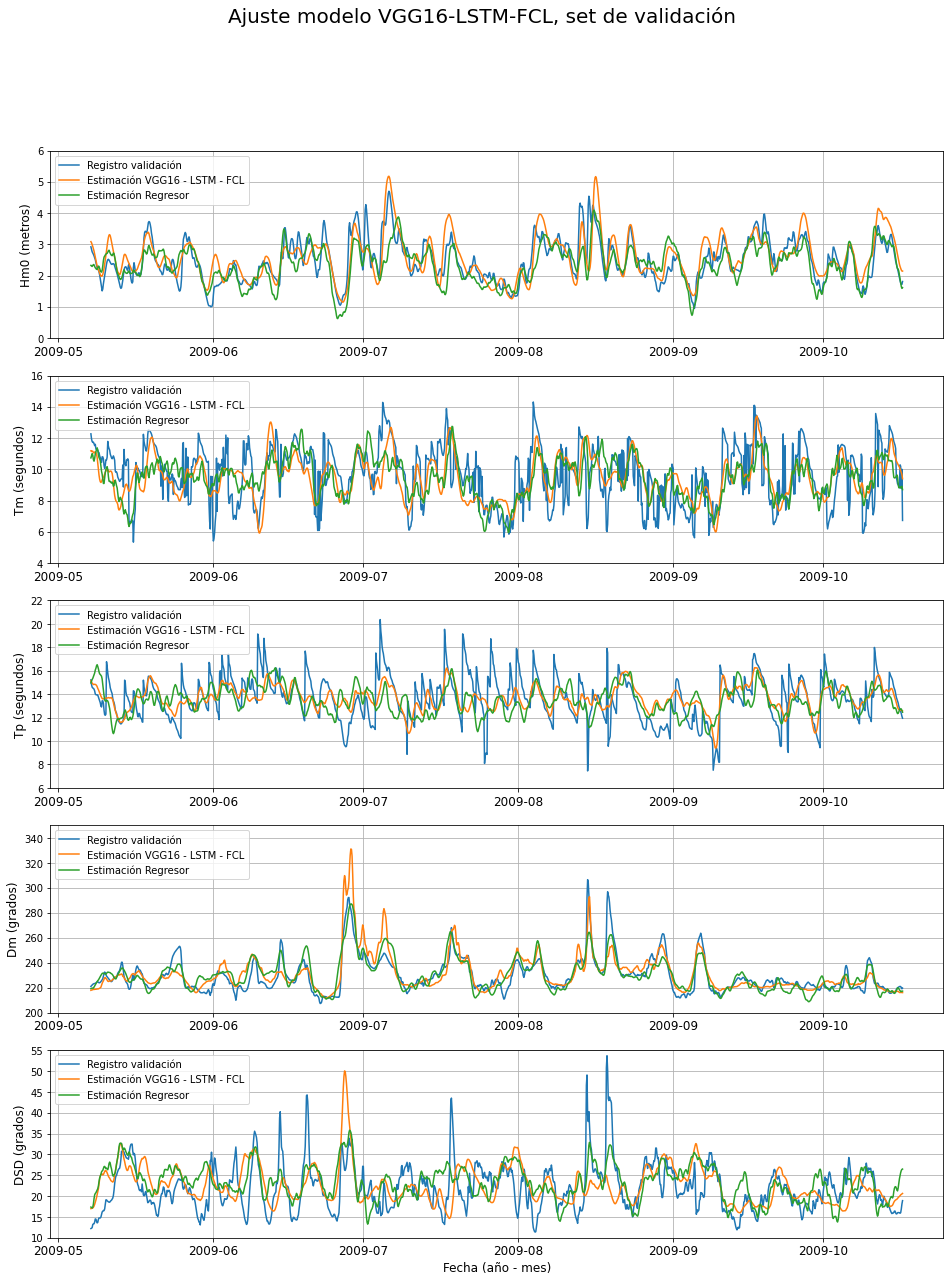

In [84]:
fig, axs = plt.subplots(5, 1, figsize=(16,20))

fig.suptitle('Ajuste modelo VGG16-LSTM-FCL, set de validación',fontsize=20)

axs[0].plot(time[-1900:-600],Hm0_test[-1900:-600],label='Registro validación')
axs[0].plot(time[-1900:-600],Hm0_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[0].plot(time[-1900:-600],pronostico[0,1][-1900:-600],label="Estimación Regresor")
axs[0].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[0].set_ylabel('Hm0 (metros)',size=12)
axs[0].set_ylim(0,6)
axs[0].legend(loc=2)
axs[0].grid()

axs[1].plot(time[-1900:-600],WP_test[-1900:-600],label='Registro validación')
axs[1].plot(time[-1900:-600],WP_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[1].plot(time[-1900:-600],pronostico[4,1][-1900:-600],label="Estimación Regresor")
axs[1].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[1].set_ylabel('Tm (segundos)',size=12)
axs[1].set_ylim(4,16)
axs[1].legend(loc=2)
axs[1].grid()


axs[2].plot(time[-1900:-600],Tp_test[-1900:-600],label='Registro validación')
axs[2].plot(time[-1900:-600],Tp_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[2].plot(time[-1900:-600],pronostico[1,1][-1900:-600],label="Estimación Regresor")
axs[2].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[2].set_ylabel('Tp (segundos)',size=12)
axs[2].set_ylim(6, 22)
axs[2].legend(loc=2)
axs[2].grid()

axs[3].plot(time[-1900:-600],MD_test[-1900:-600],label='Registro validación')
axs[3].plot(time[-1900:-600],MD_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[3].plot(time[-1900:-600],pronostico[2,1][-1900:-600],label="Estimación Regresor")
axs[3].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[3].set_ylabel('Dm (grados)',size=12)
axs[3].set_ylim(200,350)
axs[3].legend(loc=2)
axs[3].grid()

axs[4].plot(time[-1900:-600],DSD_test[-1900:-600],label='Registro validación')
axs[4].plot(time[-1900:-600],DSD_pred[-1900:-600],label="Estimación VGG16 - LSTM - FCL")
axs[4].plot(time[-1900:-600],pronostico[3,1][-1900:-600],label="Estimación Regresor")
axs[4].xaxis.set_tick_params(rotation=-0, labelsize=12)
axs[4].set_ylabel('DSD (grados)',size=12)
axs[4].set_ylim(10,55)
axs[4].set_xlabel("Fecha (año - mes)",size=12)
axs[4].legend(loc=2)
axs[4].grid()



fig.set_facecolor('w')
fig.savefig(Imagenes + 'Serie de tiempo', dpi=300)




## Espectro de oleaje completo

En esta sección se pronostica el oleaje completo, luego se calcula su calidad de ajuste usando los parámetros del espectro.

In [105]:
import funciones as fn  #Funciones de Tomás Cuevas para graficar espectro

import params_from_spectra_JH as spectra #Funciones de Tomás Cuevas para calcular parámetros del espectro, complementadas por Javier H


def plot_espectro(data,i,j,time,ax,levels,cbar=False):
    
    '''Prepara los datos obtenidos del pronóstico para graficar el espectro usando las funciones de Tomás Cuevas'''

    deltaf= i[1]-i[0]
    
    f=[]
    
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = pd.DataFrame(columns = j, index = [1/freq for freq in f], 
                        data = data[time,:,:])

    return fn.plot_spectra(df, item = None, tstep = None, 
                 figsize = (4,4), cmap = 'viridis', cbar = cbar, cbar_label = None, 
                 levels = levels, ax = ax, extend = 'both',
                 watermark = None, prdw_logo_path = None, 
                 prdw_logo_size = [0.69, 0.75, 0.15, 0.15], 
                 prdw_logo_alpha = 0.5, fig = None)


def obtener_parametros(data, i,j):
    
    '''Prepara los datos obtenidos del espectro para calcular los parámetros Hm0, Tm, Tp, Mean dir, DSD de la función en el archivo params_frm_spectra'''
    
    deltaf= i[1]-i[0]
    f=[]
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = []        
    for t in range(data.shape[0]):
        
        df.append(pd.DataFrame(columns = f, index = j, 
            data = data[t,:,:].T))
    units = 'rad'
 
    return spectra.params_from_spectra(df, item = None, units = units)




In [7]:
'''Extraemos los datos del expectro de oleaje'''

nombre = r'NCEP_Rean2_Spectra_from_Partitions_71W19S_UTC.nc'

Espectro = xr.open_dataset(Data + nombre)

Desde = '1979-01-01 03:00:00'

Hasta = '2009-12-30 21:00:00'

i = Espectro.i.data

j = Espectro.j.data

time = Espectro.Timestep.sel(Timestep = slice(Desde,Hasta)).data

Y = np.array(Espectro['Wave energy density'].sel(Timestep = slice(Desde,Hasta)))

Y = Y.reshape(Y.shape[0],Y.shape[1]*Y.shape[2])

In [110]:
'''Usar solo si el registro del espectro es cada 1 hora'''

'''Esta función se desace de 2/3 de los registros, para pasar un set de datos con oleaje cada una hora a un set de oleaje cada 3 horas'''
    
def h_to_3h(Y,time=None,X=None):
    
    if any(time) != None:
        y = np.zeros([int(Y.shape[0]/3), Y.shape[1]])

        time_3h = []

        for e in range(int(Y.shape[0]/3)):

            time_3h.append(str(time[e*3]))

            y[e,:] = Y[e*3,:]

        time = time_3h

        X = X[:y.shape[0]]

        return y, np.array(time_3h), X[:y.shape[0]]
    
    else:
        y = np.zeros([int(Y.shape[0]/3), Y.shape[1]])

        for e in range(int(Y.shape[0]/3)):

            y[e,:] = Y[e*3,:]
    
        return y

In [ ]:
Y,time,X = h_to_3h(Y,time,X)

In [102]:
traslape = 60

x_train, x_test, y_train, y_test, scy = get_set(X, Y, timestep= 1, traslape = traslape)

X_train shape:  (72411, 61, 1024)
Y_train shape:  (72411, 1, 1296)


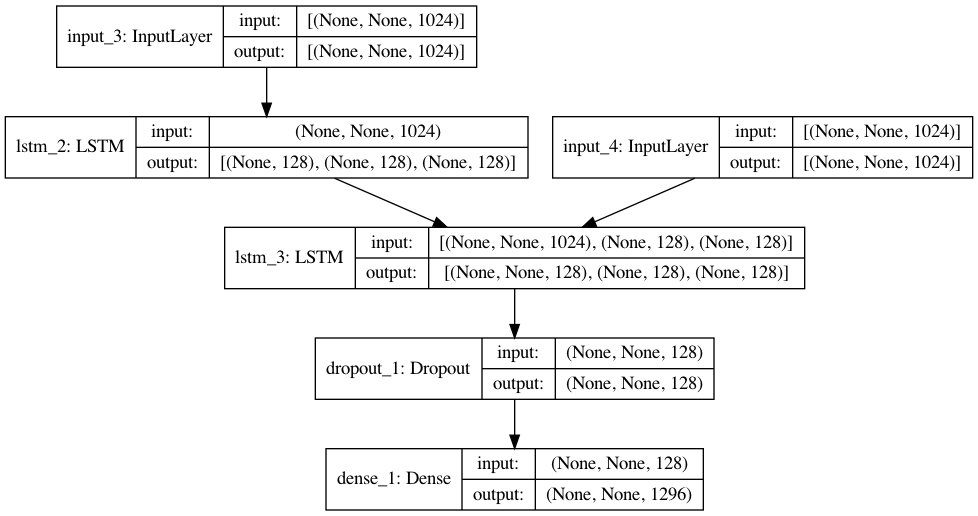

In [103]:
#Se escribe el modelo para pronosticar espectros

#Omitir, si se tiene el modelo guardado en una ocasión anterior



num_encoder_tokens = x_train.shape[2]
num_decoder_tokens = int(36*36)
hidden_units = 128

# Define an input sequence and process it.

encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder = LSTM(hidden_units, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None, num_encoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_outputs = Dropout(0.5)(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens)

decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

plot_model(model, to_file=Imagenes + 'model_espectro.png', show_shapes=True)

In [104]:
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 25,batch_size=64 ,validation_split=0.1, shuffle = True)

Epoch 1/25
1019/1019 [==============================] - 193s 183ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 2/25
1019/1019 [==============================] - 152s 149ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/25
1019/1019 [==============================] - 151s 148ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/25
1019/1019 [==============================] - 152s 149ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/25
1019/1019 [==============================] - 155s 152ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/25
1019/1019 [==============================] - 150s 147ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 7/25
1019/1019 [==============================] - 151s 149ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/25
1019/1019 [==============================] - 147s 145ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/25
1019/1019 [==============================] - 144s 142ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/25
1019/1019 [=======================

In [105]:
# Guardar el Modelo

model.save(Cache + 'Model_VGG16-LSTM_Arica.h5')

# Recrea exactamente el mismo modelo solo desde el archivo

#model = keras.models.load_model(Cache + 'Model_VGG16-LSTM_Arica.h5')

In [106]:
y_train = juntar(y_train)
y_test = juntar(y_test)

traslape = 60
m=Y.shape[0]*0.8

In [108]:
y_test = scy.inverse_transform(y_test.reshape(y_test.shape[0],1296)).reshape(y_test.shape[0],36,36)
y_train = scy.inverse_transform(y_train.reshape(y_train.shape[0],1296)).reshape(y_train.shape[0],36,36)

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))
y_pred_test = y_pred_test.reshape(y_pred_test.shape[0],36,36)

#y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:,:traslape,:],x_train[:,traslape:,:]])))
#y_pred_train = y_pred_train.reshape(y_pred_train.shape[0],36,36)

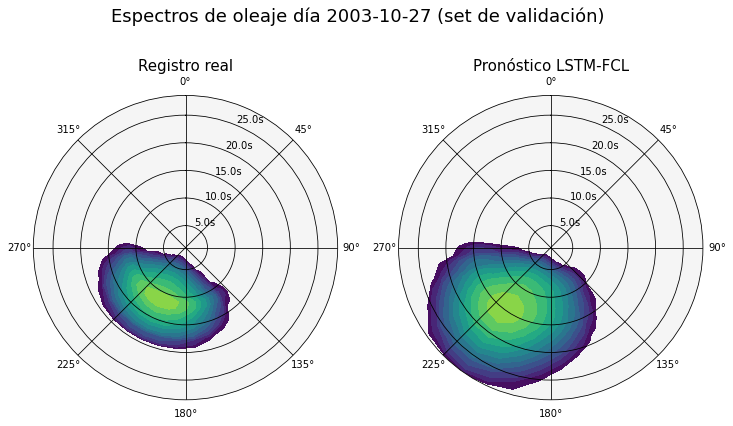

In [117]:
#Graficamos los resultados para tener una idea de la diferencia de los espectros

indice = 0

levels = np.geomspace(0.01, 25, 15)

fig, axs = plt.subplots(1,2,figsize = (12,7), subplot_kw = dict(projection = 'polar'))#fig.suptitle('Vertically stacked subplots')

fig.suptitle('Espectros de oleaje día '+str(time[int(m+traslape +indice)])[:10] + ' (set de validación)',fontsize=18)

plot_espectro(y_test_filtrado,i,j,indice,axs[0],levels)

axs[0].set_title('Registro real',fontsize=15)

plot_espectro(np.round(y_pred_test_filtrado,3),i,j,indice,axs[1],levels)

axs[1].set_title('Pronóstico LSTM-FCL',fontsize=15)

fig.set_facecolor('w')

fig.savefig(Imagenes + "Espectro_trainset_LSTM_sinfiltro",dpi=300)

In [111]:
#se guardan los resultados del modelo.

np.save(Cache + 'Espectro_VGG16-LSTM_Arica_test.npy', y_test)
np.save(Cache + 'Espectro_VGG16-LSTM_Arica_pred.npy', y_pred_test)

In [12]:
#se cargan los resultados del modelo

y_test = np.load(Cache + 'Espectro_VGG16-LSTM_test.npy')
y_pred_test = np.load(Cache + 'Espectro_VGG16-LSTM_pred.npy')

In [7]:
def filtrar(Y, f1,f2,g1,g2):
    
    '''Esta función permite filtrar entre frecuencias f1 y f2 y entre grados de dirección g1 y g2. 
    tanto f, como g son in que van de 0-36 según las listas i, j guardadas anteriormente'''

    filtro = np.zeros([36,36])

    for frec in range(f1,f2):
        
        for grad in range(g1,g2):

            filtro[frec,grad]= 1

    return Y*filtro

In [126]:
#Aquí filtramos la información a trabajar. esto nos permite poder visualizar errores para distintos conjuntos de datos.

y_test_filtrado = filtrar(y_test,0,36,13,29)

y_pred_test_filtrado = filtrar(y_pred_test,0,36,13,29)

#usamos obtener parámetros para obtener los parametros del espectro pronosticado y observado

Hm0_spectra_obs,Tp_spectra_obs, MD_spectra_obs,Tm_spectra_obs, DSD_spectra_obs = obtener_parametros(y_test_filtrado,i,j)

Hm0_spectra_pred, Tp_spectra_pred, MD_spectra_pred, Tm_spectra_pred, DSD_spectra_pred = obtener_parametros(np.round(y_pred_test_filtrado,1),i,j)

<class 'list'>
<class 'list'>


In [127]:
# en los espectro pronosticados, debido a un ruido se producen errores de cálculo al estimar los parametros, por lo que se borran los Nan

nan = np.isnan(DSD_spectra_pred)
dsd1 =[]
dsd2 =[]
for w in range(len(DSD_spectra_pred)):
    if not nan[w] :
        dsd1.append(DSD_spectra_pred[w])
        dsd2.append(DSD_spectra_obs[w])
        
nan = np.isnan(Hm0_spectra_pred)
hm01 =[]
hm02 =[]
for w in range(len(Hm0_spectra_pred)):
    if not nan[w] :
        hm01.append(Hm0_spectra_pred[w])
        hm02.append(Hm0_spectra_obs[w])

In [128]:
variable = ['Hm0','Tm', 'Tp','MD', 'DSD']

pred = [hm01, Tm_spectra_pred, Tp_spectra_pred, MD_spectra_pred, dsd1]

obs = [hm02, Tm_spectra_obs, Tp_spectra_obs, MD_spectra_obs, dsd2]

for e in range(0,len(variable)):

    print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),np.array(obs[e])),2))
          
    

Hm0, r:  0.77  RMSE:  0.3
Tm, r:  0.6  RMSE:  1.49
Tp, r:  0.3  RMSE:  2.03
MD, r:  0.78  RMSE:  4.17
DSD, r:  0.53  RMSE:  2.91


### Análisis por estaciones

Primavera: del 23 de septiembre al 21 de diciembre.

Verano: del 21 de diciembre al 20 de marzo.

Otoño: del 20 de marzo al 21 de junio.

Invierno: del 21 de junio al 23 de septiembre.

In [121]:
test_time = np.array(time[-y_test.shape[0]:]) #Fechas del tiempo del set de validación

In [122]:
#Se rescatan los ínidices que nos permitiran segmentar entre estación del año los datos del espectro pronosticado y real.

for cor in range(test_time.shape[0]):

    if '2004-09-23T00:00:00.000000000' == str(test_time[cor]):primavera = cor
        
    if '2003-12-21T00:00:00.000000000' == str(test_time[cor]):verano = cor

    if '2004-03-20T00:00:00.000000000' == str(test_time[cor]):otoño = cor

    if '2004-06-21T00:00:00.000000000' == str(test_time[cor]):invierno = cor




In [123]:
def estaciones(lista):
    
    '''Separa la lista en 4 listas por estación, reconociendo que cada año dura 2920 registros cada 3 horas'''
    
    set_p = np.zeros([1,36,36])
    set_v = np.zeros([1,36,36])
    set_o = np.zeros([1,36,36])
    set_i = np.zeros([1,36,36])
    año = 2920
    
    for x in range(0,lista.shape[0], año):
      
        set_p = np.append(set_p,lista[primavera +x:verano+x+año],axis=0)
        set_v = np.append(set_v,lista[verano+x:otoño+x],axis=0)
        set_o = np.append(set_o,lista[otoño +x:invierno+x],axis=0)
        set_i = np.append(set_i,lista[invierno+x:primavera+x],axis=0)
        
    return set_p , set_v , set_o, set_i

In [125]:

estacion=['Primavera','Verano','Otoño','Invierno']

set_p , set_v , set_o, set_i = estaciones(y_test_filtrado)

set_p2 , set_v2 , set_o2, set_i2 = estaciones(y_pred_test_filtrado)

sets = [set_p , set_v , set_o, set_i]

sets2 = [set_p2 , set_v2 , set_o2, set_i2]

for z in range(4):

    print('---------------------------------')
    print(estacion[z])

    Hm0_spectra_obs,Tp_spectra_obs, MD_spectra_obs,Tm_spectra_obs, DSD_spectra_obs,D_spectra_obs = obtener_parametros(np.array(sets[z]),i,j)

    Hm0_spectra_pred, Tp_spectra_pred, MD_spectra_pred, Tm_spectra_pred, DSD_spectra_pred,D_spectra_obs = obtener_parametros(np.round(np.array(sets2[z]),1),i,j)



    #El espectro pronosticado, tiene iregularidades que presentan problema
    #cuando se extraen los parametros y retorna Nan. Por lo que en estas funciones se filtra dicho problema.
    #-----------------------------------------
    nan = np.isnan(DSD_spectra_pred)
    dsd1 =[]
    dsd2 =[]
    for w in range(len(DSD_spectra_pred)):
        if not nan[w] :
            dsd1.append(DSD_spectra_pred[w])
            dsd2.append(DSD_spectra_obs[w])

    nan = np.isnan(Hm0_spectra_pred)
    hm01 =[]
    hm02 =[]
    for w in range(len(Hm0_spectra_pred)):
        if not nan[w] :
            hm01.append(Hm0_spectra_pred[w])
            hm02.append(Hm0_spectra_obs[w])

    nan = np.isnan(Tm_spectra_obs)
    tm01 =[]
    tm02 =[]
    for w in range(len(Tm_spectra_pred)):
        if not nan[w] :
            tm01.append(Tm_spectra_pred[w])
            tm02.append(Tm_spectra_obs[w])
    #-----------------------------------------




    variable = ['Hm0','Tm', 'Tp','MD', 'DSD']

    pred = [hm01, tm01, Tp_spectra_pred, MD_spectra_pred, dsd1]

    obs = [hm02, tm02, Tp_spectra_obs, MD_spectra_obs, dsd2]



    for e in range(0,len(variable)):

        print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),np.array(obs[e])),2))

---------------------------------
Primavera
<class 'list'>


/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:88: RuntimeWarning: invalid value encountered in double_scalars
  tm01.append( m0/m1)
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:96: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(np.multiply(aux.values, np.sin(np.radians(dfi.index))))/m0*dtheta*deltaf
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:97: RuntimeWarning: invalid value encountered in double_scalars
  a = np.sum(np.multiply(aux.values, np.cos(np.radians(dfi.index))))/m0*dtheta*deltaf


<class 'list'>
Hm0, r:  0.76  RMSE:  0.3
Tm, r:  0.63  RMSE:  1.5
Tp, r:  0.35  RMSE:  1.98
MD, r:  0.83  RMSE:  3.57
DSD, r:  0.63  RMSE:  2.24
---------------------------------
Verano
<class 'list'>
<class 'list'>
Hm0, r:  0.62  RMSE:  0.27
Tm, r:  0.49  RMSE:  1.69
Tp, r:  0.25  RMSE:  2.13
MD, r:  0.79  RMSE:  3.65
DSD, r:  0.37  RMSE:  4.2
---------------------------------
Otoño
<class 'list'>
<class 'list'>
Hm0, r:  0.69  RMSE:  0.3
Tm, r:  0.56  RMSE:  1.32
Tp, r:  0.22  RMSE:  1.84
MD, r:  0.82  RMSE:  4.38
DSD, r:  0.64  RMSE:  2.18
---------------------------------
Invierno
<class 'list'>
<class 'list'>
Hm0, r:  0.76  RMSE:  0.34
Tm, r:  0.62  RMSE:  1.42
Tp, r:  0.3  RMSE:  2.16
MD, r:  0.83  RMSE:  4.9
DSD, r:  0.61  RMSE:  2.58


### Estimación espectros de oleaje periodo 2010 -2020
En esta sección se completan los espectros del 2010 al 2020.

In [59]:
'''Extraemos los features guardados del programa Obtención de características para el período 2010-2020'''

X = np.load(Cache + 'x_features_VGG(2010-2020).npy')

X =resize(X,3)

X = flatten(X)

h3 =False
'''Extraemos el Y a pronosticar y el modelo'''

lugar = input('Seleccione localidad a pronosticar: ')

if lugar == 'Arica'or lugar == 'A':

    nombre = r'NCEP_Oper_Spectra_from_Partitions_71W19.5S_UTC.nc'  #Arica    
    
    model = keras.models.load_model(Cache + 'Model_VGG16-LSTM_Arica.h5')
    
    X = X[31895:] #23375:] #se parte desde el 2018-01-01 en lugar del 2010-01-01
    
    Desde = '2018-12-01 00:00:00'

    Hasta = '2018-12-30 21:00:00'
    
elif lugar == 'Concepción'or lugar == 'C':
  
    nombre = r'NCEP_Spectra_from_Partitions_36.5S_74.0W_201001to201811_1H.nc'  #Concepción
    
    model = keras.models.load_model(Cache + 'Model_VGG16-LSTM_Conce.h5')
    
    Desde = '2010-01-01 03:00:00'

    Hasta = '2018-12-30 21:00:00'
    
    h3 =True

else :   
    nombre = r'NCEP_Spectra_from_Partitions_33.5S_72.0W_201001to201712.nc'  #Valparaíso
    
    model = keras.models.load_model(Cache + 'Model_VGG16-LSTM.h5')
    
    Desde = '2010-01-01 03:00:00'

    Hasta = '2017-12-30 21:00:00'

    X = X[:23367]
    
    
Espectro = xr.open_dataset(Data + nombre)

i = Espectro.i.data

j = Espectro.j.data

time = Espectro.Timestep.sel(Timestep = slice(Desde,Hasta)).data

Y = np.array(Espectro['Wave energy density'].sel(Timestep = slice(Desde,Hasta)))

Y = Y.reshape(Y.shape[0],Y.shape[1]*Y.shape[2])

if h3 :
    Y,time,X = h_to_3h(Y,time,X)


Seleccione localidad a pronosticar: V


In [62]:
'''Hacemos el siguiente proceso con cada región de interés'''

traslape = 60

x_train, x_test, y_train, y_test, scy = get_set(X, Y, timestep= 1, traslape = traslape)

X = np.append(x_train,x_test, axis=0)
Y = np.append(y_train,y_test, axis=0)

X_train shape:  (18644, 61, 1024)
Y_train shape:  (18644, 1, 1296)


In [63]:
Y = juntar(Y)

m = Y.shape[0]

Y = scy.inverse_transform(Y.reshape(m,1296)).reshape(m,36,36)

Y_pred = scy.inverse_transform(juntar(model.predict([X[:,:traslape,:],X[:,traslape:,:]])))

Y_pred = Y_pred.reshape(m,36,36)

In [64]:
#Aquí filtramos la información a trabajar. esto nos permite poder visualizar errores para distintos conjuntos de datos.

y_test_filtrado = filtrar(Y,0,36,13,29)

y_pred_test_filtrado = filtrar(Y_pred,0,36,13,29)

#usamos obtener parámetros para obtener los parametros del espectro pronosticado y observado

Hm0_spectra_obs,Tp_spectra_obs, MD_spectra_obs,Tm_spectra_obs, DSD_spectra_obs, Dp_spectra_obs = obtener_parametros(y_test_filtrado,i,j)

Hm0_spectra_pred, Tp_spectra_pred, MD_spectra_pred, Tm_spectra_pred, DSD_spectra_pred, Dp_spectra_pred = obtener_parametros(np.round(y_pred_test_filtrado,1),i,j)

<class 'list'>


/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:99: RuntimeWarning: invalid value encountered in double_scalars
  tm01.append( m0/m1)
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:107: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(np.multiply(aux.values, np.sin(np.radians(dfi.index))))/m0*dtheta*deltaf
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:108: RuntimeWarning: invalid value encountered in double_scalars
  a = np.sum(np.multiply(aux.values, np.cos(np.radians(dfi.index))))/m0*dtheta*deltaf


<class 'list'>


/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/params_from_spectra_JH.py:109: RuntimeWarning: invalid value encountered in double_scalars
  dsd.append(np.mod(np.degrees((2*(1-(a**2 + b**2)**0.5))**0.5),360))


/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/funciones.py:333: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under('whitesmoke')
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/funciones.py:338: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if levels == 'auto':
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/funciones.py:348: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{}s'.format(x) for x in ax.get_yticks()])


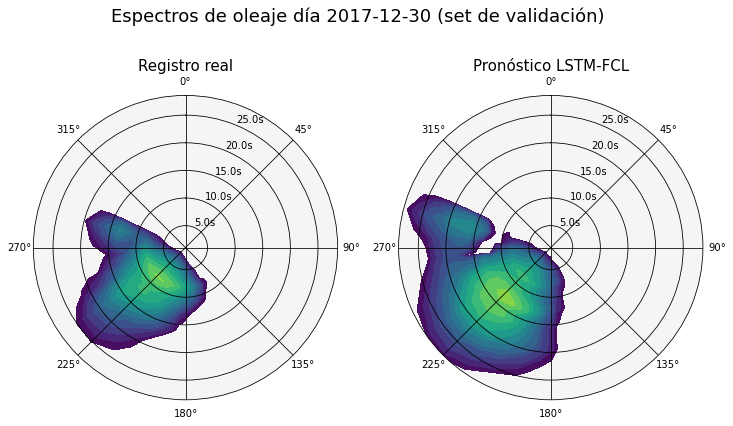

In [65]:
'''Graficamos opcionalmente'''

indice = 0

levels = np.geomspace(0.01, 25, 15)

fig, axs = plt.subplots(1,2,figsize = (12,7), subplot_kw = dict(projection = 'polar'))#fig.suptitle('Vertically stacked subplots')

fig.suptitle('Espectros de oleaje día '+str(time[int(m+traslape +indice)])[:10] + ' (set de validación)',fontsize=18)

plot_espectro(y_test_filtrado,i,j,indice,axs[0],levels)

axs[0].set_title('Registro real',fontsize=15)

plot_espectro(np.round(y_pred_test_filtrado,3),i,j,indice,axs[1],levels)

axs[1].set_title('Pronóstico LSTM-FCL',fontsize=15)

fig.set_facecolor('w')


In [67]:
# en los espectro pronosticados, debido a un ruido se producen errores de cálculo al estimar los parametros, por lo que se borran los Nan

nan = np.isnan(DSD_spectra_pred)
nan2 = np.isnan(DSD_spectra_obs)
dsd1 =[]
dsd2 =[]
for w in range(len(DSD_spectra_pred)):
    if not (nan[w] or nan2[w])  :
        dsd1.append(DSD_spectra_pred[w])
        dsd2.append(DSD_spectra_obs[w])
        
nan = np.isnan(Hm0_spectra_pred)
hm01 =[]
hm02 =[]
for w in range(len(Hm0_spectra_pred)):
    if not nan[w] :
        hm01.append(Hm0_spectra_pred[w])
        hm02.append(Hm0_spectra_obs[w])
        
nan = np.isnan(Tm_spectra_pred)
nan2 = np.isnan(Tm_spectra_obs)
tm1 =[]
tm2 =[]
for w in range(len(Tm_spectra_pred)):
    if not (nan[w] or nan2[w]) :
        tm1.append(Tm_spectra_pred[w])
        tm2.append(Tm_spectra_obs[w])
        
nan = np.isnan(Tp_spectra_pred)
nan2 = np.isnan(Tp_spectra_obs)
tp1 =[]
tp2 =[]
for w in range(len(Tp_spectra_pred)):
    if not (nan[w] or nan2[w]) :
        tp1.append(Tp_spectra_pred[w])
        tp2.append(Tp_spectra_obs[w])
        
nan = np.isnan(Dp_spectra_pred)
nan2 = np.isnan(Dp_spectra_obs)
Dp1 =[]
Dp2 =[]
for w in range(len(Dp_spectra_pred)):
    if not (nan[w] or nan2[w]) :
        Dp1.append(Dp_spectra_pred[w])
        Dp2.append(Dp_spectra_obs[w])
        
        
variable = ['Hm0','Tm', 'Tp','MD', 'DSD', 'Dp']

pred = [hm01, tm1, tp1, MD_spectra_pred, dsd1, Dp1]

obs = [hm02, tm2, tp2, MD_spectra_obs, dsd2, Dp2]

for e in range(0,len(variable)):

    print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),np.array(obs[e])),2))
          
    

Hm0, r:  0.74  RMSE:  0.45
Tm, r:  0.57  RMSE:  1.8
Tp, r:  0.15  RMSE:  2.31
MD, r:  0.67  RMSE:  7.54
DSD, r:  0.4  RMSE:  3.6
Dp, r:  0.38  RMSE:  12.81


## Comparación pronósticos NCEP contra pronósticos NN.

In [107]:
def obtener_parametros_de_nc(ruta, Desde, Hasta):
    
    '''Prepara los datos obtenidos del espectro para calcular los parámetros Hm0, Tm, Tp, Mean dir, DSD de la función en el archivo params_frm_spectra'''
    
    Espectro = xr.open_dataset(ruta)

    i = Espectro.i.data

    j = Espectro.j.data
    
    data = np.array(Espectro['Wave energy density'].sel(Timestep = slice(Desde,Hasta)))

    
    
    deltaf= i[1]-i[0]
    
    f=[]
    
    for a in range(i.shape[0]):
        if deltaf<1:
            f.append(float(i[0] + a*deltaf))
        else:
            f.append(float(i[0]*deltaf**a))

    df = []        
    for t in range(data.shape[0]):
        
        df.append(pd.DataFrame(columns = f, index = j, 
            data = data[t,:,:].T))
    units = 'rad'
 
    return spectra.params_from_spectra(df, item = None, units = units)

In [108]:
Parametros_arica =  obtener_parametros_de_nc(Data + r'NCEP_Oper_Spectra_from_Partitions_71W19.5S_UTC.nc', '2018-12-01 00:00:00', '2019-02-01 00:00:00')

Parametros_conce_1h =  obtener_parametros_de_nc(Data + r'NCEP_Spectra_from_Partitions_36.5S_74.0W_201001to201811_1H.nc', '2013-01-01 03:00:00', '2013-07-21 00:00:00')

Parametros_valpo =  obtener_parametros_de_nc(Data + r'NCEP_Spectra_from_Partitions_33.5S_72.0W_201001to201712.nc', '2014-03-27 03:00:00', '2014-12-21 15:00:00')

<class 'list'>
<class 'list'>


/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/Códigos completos/params_from_spectra_JH.py:99: RuntimeWarning: invalid value encountered in double_scalars
  tm01.append( m0/m1)
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/Códigos completos/params_from_spectra_JH.py:107: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(np.multiply(aux.values, np.sin(np.radians(dfi.index))))/m0*dtheta*deltaf
/Users/javier/Documents/GitHub/Codigo_Javier_PRDW/Códigos completos/params_from_spectra_JH.py:108: RuntimeWarning: invalid value encountered in double_scalars
  a = np.sum(np.multiply(aux.values, np.cos(np.radians(dfi.index))))/m0*dtheta*deltaf


<class 'list'>


In [111]:
#Transformamos a registro cada 3 horas

Parametros_conce = []

for parametro in Parametros_conce_1h:
    
    Parametros_conce.append(h_to_3h(np.array(parametro).reshape(-1,1)))

TypeError: 'NoneType' object is not iterable

In [112]:
#Extraemos los pronósticos NCEP 

import openpyxl as xl

excel = xl.load_workbook(Data + 'DataNodos_Tesis.xlsm')


In [14]:
#Con este código extraemos los datos del excel para comparalos con los registros.

Pronostico_arica = []

Desde =  '2018-12-01 00:00:00'

Hasta =  '2019-02-01 03:00:00'

time = excel.get_sheet_by_name('Nodo 1')['A']

for e in 'NOP':  #Columnas del excel
    
    parametro = excel.get_sheet_by_name('Nodo 1')[e]
    
    l = 0; var = []
    
    for t in range(len(time)):
        
        if str(time[t].value) == Desde or str(time[t].value) == Hasta :  l +=1            
        
        if l ==1:  var.append(parametro[t].value)        

    Pronostico_arica.append(var)
    
    
    
Pronostico_conce = []

Desde =  '2013-01-01 03:00:00'

Hasta =  '2013-07-21 00:00:00'

time = excel.get_sheet_by_name('Nodo 3')['A']

for e in 'NOP':
    
    parametro = excel.get_sheet_by_name('Nodo 3')[e]
    
    l = 0; var = []
    
    for t in range(len(time)):
        
        if str(time[t].value) == Desde or str(time[t].value) == Hasta :  l +=1            
        
        if l ==1:  var.append(parametro[t].value)
            
    Pronostico_conce.append(var)
    
    
Pronostico_valpo = []

Desde =  '2014-03-27 03:00:00'

Hasta =  '2014-12-21 18:00:00'

time = excel.get_sheet_by_name('Nodo 2')['A']

for e in 'NOP':
    
    parametro = excel.get_sheet_by_name('Nodo 2')[e]
    
    l = 0; var = []
    
    for t in range(len(time)):
        
        if str(time[t].value) == Desde or str(time[t].value) == Hasta :  l +=1            
        
        if l ==1:  var.append(parametro[t].value)
            
    Pronostico_valpo.append(var)

<ipython-input-14-15007f924946>:9: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  time = excel.get_sheet_by_name('Nodo 1')['A']
<ipython-input-14-15007f924946>:13: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  parametro = excel.get_sheet_by_name('Nodo 1')[e]
<ipython-input-14-15007f924946>:33: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  time = excel.get_sheet_by_name('Nodo 3')['A']
<ipython-input-14-15007f924946>:37: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  parametro = excel.get_sheet_by_name('Nodo 3')[e]
<ipython-input-14-15007f924946>:56: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  time = excel.get_sheet_by_name('Nodo 2')['A']
<ipython-input-14-15007f924946>:60: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  parametro = exc

In [113]:
    
Pronostico_valpo = []

Desde =  '2014-03-27 03:00:00'

Hasta =  '2014-12-21 18:00:00'

time = excel.get_sheet_by_name('Nodo 2')['A']

for e in 'NOP':
    
    parametro = excel.get_sheet_by_name('Nodo 2')[e]
    
    l = 0; var = []
    
    for t in range(len(time)):
        
        if str(time[t].value) == Desde or str(time[t].value) == Hasta :  l +=1            
        
        if l ==1:  var.append(parametro[t].value)
            
    Pronostico_valpo.append(var)

<ipython-input-113-d916a15db2f6>:7: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  time = excel.get_sheet_by_name('Nodo 2')['A']
<ipython-input-113-d916a15db2f6>:11: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  parametro = excel.get_sheet_by_name('Nodo 2')[e]


In [120]:
    
print('Valparaíso')
variable = ['Hm0', 'Tp','Dm']

pred = [ Pronostico_valpo[0], Pronostico_valpo[1],Pronostico_valpo[2]]

obs = [Parametros_valpo[0],Parametros_valpo[1],Parametros_valpo[2]]

for e in range(0,3):

    print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),np.array(obs[e])),2))

Valparaíso
Hm0, r:  0.94  RMSE:  0.35
Tp, r:  0.68  RMSE:  1.88
Dm, r:  0.66  RMSE:  14.84


In [19]:


variable = ['Hm0', 'Tp','Dp']

pred = [ Pronostico_arica[0], Pronostico_arica[1],Pronostico_arica[2]]

obs = [Parametros_arica[0],Parametros_arica[1],Parametros_arica[5]]

print('Arica')

for e in range(0,len(variable)):

    print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),np.array(obs[e])),2))
    
    
print('Concepción')

pred = [Pronostico_conce[0], Pronostico_conce[1],Pronostico_conce[2]]

obs = [Parametros_conce[0].reshape(1607,),Parametros_conce[1].reshape(1607,),Parametros_conce[5].reshape(1607,)]

for e in range(0,len(variable)):

    print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),obs[e]),2))
    
    
print('Valparaíso')

pred = [ Pronostico_valpo[0], Pronostico_valpo[1],Pronostico_valpo[2]]

obs = [Parametros_valpo[0],Parametros_valpo[1],Parametros_valpo[5]]

for e in range(0,len(variable)):

    print( variable[e] + ', r: ', np.round(np.corrcoef(pred[e],obs[e])[0,1],2), ' RMSE: ', np.round(RMSE(np.array(pred[e]),np.array(obs[e])),2))

Arica
Hm0, r:  0.97  RMSE:  0.05
Tp, r:  0.64  RMSE:  2.2
Dp, r:  0.72  RMSE:  30.06
Concepción
Hm0, r:  0.93  RMSE:  0.44
Tp, r:  0.52  RMSE:  2.8
Dp, r:  0.36  RMSE:  30.3
Valparaíso
Hm0, r:  0.94  RMSE:  0.35
Tp, r:  0.68  RMSE:  1.88
Dp, r:  0.63  RMSE:  16.68
